In [98]:
import numpy as np
import json
import os
import pickle
import xrt.backends.raycing.sources as rsources
from scipy.optimize import minimize
import params

%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors

matplotlib.use("pgf")

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
        r"\usepackage[T2A]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english,russian]{babel}",
    ]),
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.figsize': [4.75, 4.75 * 9 / 16],
    'figure.dpi': 200
})

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator, LinearLocator, MaxNLocator
from utils.various import datafiles
from utils.xrtutils import get_integral_breadth, bell_fit, get_line_kb

def get_inf_points(xs, ys, expand=[1.1, 1.4]):
    pos_inf_y = np.mean(ys[np.isinf(xs) & (xs > 0)])
    neg_inf_y = np.mean(ys[np.isinf(xs) & (xs < 0)])
    
    pos_inf_x = np.max(xs[~np.isinf(xs)])
    neg_inf_x = np.min(xs[~np.isinf(xs)])
    dist = pos_inf_x - neg_inf_x
    
    return ([neg_inf_x + dist * expand[0], neg_inf_x + dist * expand[1]], [pos_inf_y, pos_inf_y]), \
        ([pos_inf_x - dist * expand[0], pos_inf_x - dist * expand[1]], [neg_inf_y, neg_inf_y])

# Конвенция про +/-

## Фокус: 
* ПОЛОЖИТЕЛЬНЫЙ если он со стороны источника
* ОТРИЦАТЕЛЬНЫЙ если он со стороны образца

## Радиус:
* ПОЛОЖИТЕЛЬНЫЙ если изгиб вокруг источника
* ОТРИЦАТЕЛЬНЫЙ если изгиб вокруг образца

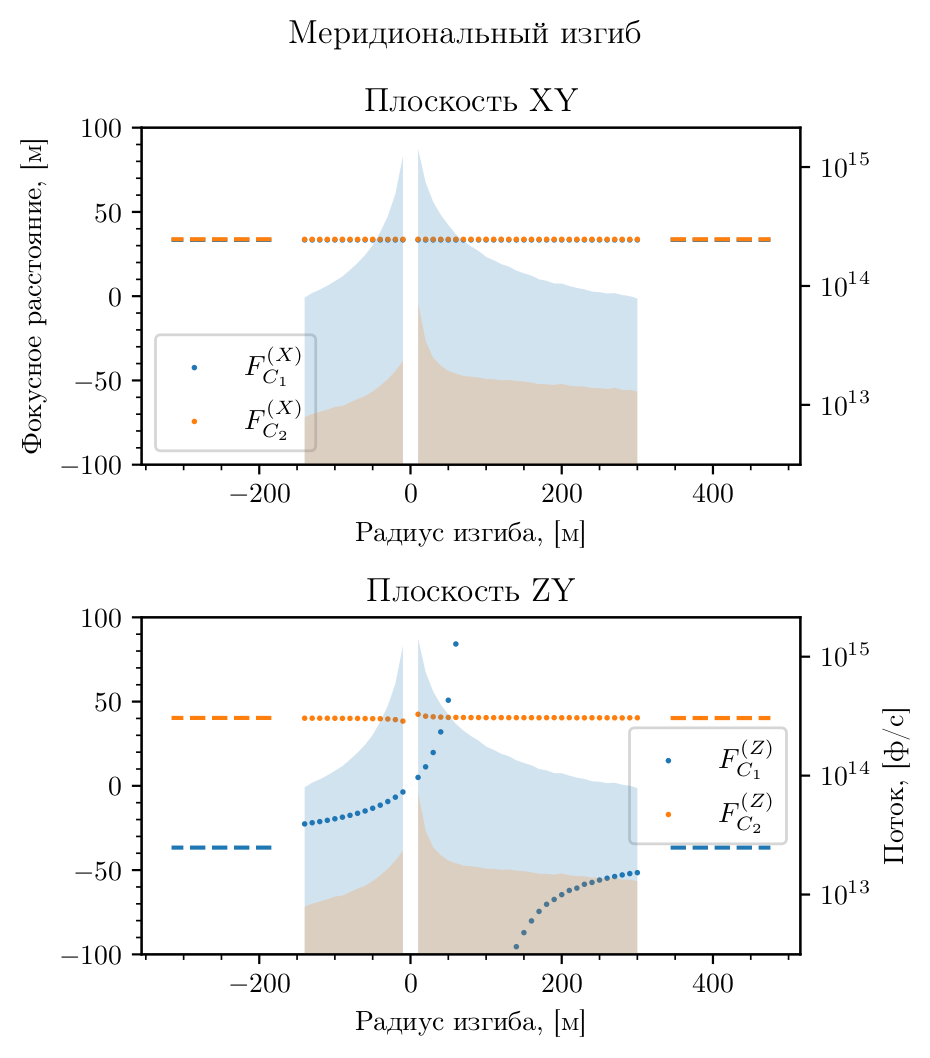

In [99]:
dd = '/Users/glebdovzhenko/Dropbox/PycharmProjects/skif-xrt/datasets/skif15/get_focus_m'

c1c2_cr_dist = np.sqrt(np.sum((np.array([0.0, 33594.21541931476, 12.5]) - np.array([0.0, 33500.0, 0.0]))**2))
em_cr_dist = np.sqrt(np.sum((np.array([0, 114990.0, 25.0]) - np.array([0.0, 33688.43083862951, 25.0]))**2))

r1x, r2x, r1y, r2y, r1_, r2_, f1x, f2x, f1y, f2y, flux1, flux2 = [], [], [], [], [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    
    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        k, b = get_line_kb(data, show=False)
        fdist = -np.sign(k) * np.sqrt((1. / k) ** 2 + (b / k) ** 2)
        
        if (metadata['name'] == 'C1C2') & (metadata['axes'] == 'XXpr'):
            f1x.append(-fdist + c1c2_cr_dist)
            r1x.append(metadata['r1'])
        elif (metadata['name'] == 'C1C2') & (metadata['axes'] == 'ZZpr'):
            f1y.append(-fdist + c1c2_cr_dist)
            r1y.append(metadata['r1'])
        elif (metadata['name'] == 'EM') & (metadata['axes'] == 'XXpr'):
            f2x.append(-fdist - em_cr_dist)
            r2x.append(metadata['r1'])
        elif (metadata['name'] == 'EM') & (metadata['axes'] == 'ZZpr'):
            f2y.append(-fdist - em_cr_dist)
            r2y.append(metadata['r1'])
        elif (metadata['name'] == 'C1C2') & (metadata['axes'] == 'XZ'):
            r1_.append(metadata['r1'])
            flux1.append(data.flux)
        elif (metadata['name'] == 'EM') & (metadata['axes'] == 'XZ'):
            r2_.append(metadata['r1'])
            flux2.append(data.flux)
        
r1x, r2x, r1y, r2y, r1_, r2_, f1x, f2x, f1y, f2y, flux1, flux2 = np.array(r1x), np.array(r2x), np.array(r1y), np.array(r2y), np.array(r1_), np.array(r2_), \
    np.array(f1x), np.array(f2x), np.array(f1y), np.array(f2y), np.array(flux1), np.array(flux2)
f1x *= 1e-3; f2x *= 1e-3; f1y *= 1e-3; f2y *= 1e-3
ii1 = np.argsort(r1_)
ii2 = np.argsort(r2_)
r1_, r2_, flux1, flux2 = r1_[ii1], r2_[ii2], flux1[ii1], flux2[ii2]

f1xp, f1xn = get_inf_points(r1x, f1x)
f2xp, f2xn = get_inf_points(r2x, f2x)
f1yp, f1yn = get_inf_points(r1y, f1y)
f2yp, f2yn = get_inf_points(r2y, f2y)

plt.close(fig)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.75, 4.75 * 18 / 16))
fig.suptitle('Меридиональный изгиб')

ax1f = ax1.twinx()
ax1f.fill_between(r1_[r1_ > 0], flux1[r1_ > 0], np.ones(shape=flux1[r1_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1f.fill_between(r1_[r1_ < 0], flux1[r1_ < 0], np.ones(shape=flux1[r1_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1f.fill_between(r2_[r2_ > 0], flux2[r2_ > 0], np.zeros(shape=flux2[r2_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1f.fill_between(r2_[r2_ < 0], flux2[r2_ < 0], np.zeros(shape=flux2[r2_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1f.set_yscale('log')
ax1f.set_ylim(0.5 * np.min(flux2), 1.5 * np.max(flux1))

ax1.scatter(r1x, f1x, label='$F_{C_1}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:blue'], s=1)
ax1.scatter(r2x, f2x, label='$F_{C_2}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:orange'], s=1)
ax1.plot(*f1xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f1xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f2xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.plot(*f2xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.set_xlabel('Радиус изгиба, [м]')
ax1.set_ylabel('Фокусное расстояние, [м]')
ax1.set_title('Плоскость XY')
ax1.legend()

ax2f = ax2.twinx()
ax2f.fill_between(r1_[r1_ > 0], flux1[r1_ > 0], np.ones(shape=flux1[r1_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2f.fill_between(r1_[r1_ < 0], flux1[r1_ < 0], np.ones(shape=flux1[r1_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2f.fill_between(r2_[r2_ > 0], flux2[r2_ > 0], np.zeros(shape=flux2[r2_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2f.fill_between(r2_[r2_ < 0], flux2[r2_ < 0], np.zeros(shape=flux2[r2_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2f.set_yscale('log')
ax2f.set_ylim(0.5 * np.min(flux2), 1.5 * np.max(flux1))
ax2f.set_ylabel('Поток, [ф/с]')

ax2.scatter(r1y, f1y, label='$F_{C_1}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:blue'], s=1)
ax2.scatter(r2y, f2y, label='$F_{C_2}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:orange'], s=1)
ax2.plot(*f1yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f1yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f2yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.plot(*f2yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.set_xlabel('Радиус изгиба, [м]')
ax2.set_title('Плоскость ZY')
ax2.legend()

ax1.set_ylim(-100, 100)
ax2.set_ylim(-100, 100)
# ax1.set_ylim(30, 40)
# ax2.set_ylim(30, 40)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax1f.yaxis.set_minor_locator(LogLocator(numticks=15))
ax2f.yaxis.set_minor_locator(LogLocator(numticks=15))
plt.tight_layout()

plt.savefig('focusing/meridional.pgf')
plt.savefig('focusing/meridional.pdf')

meridional_f = np.stack((r1y, f1y)).T

fig

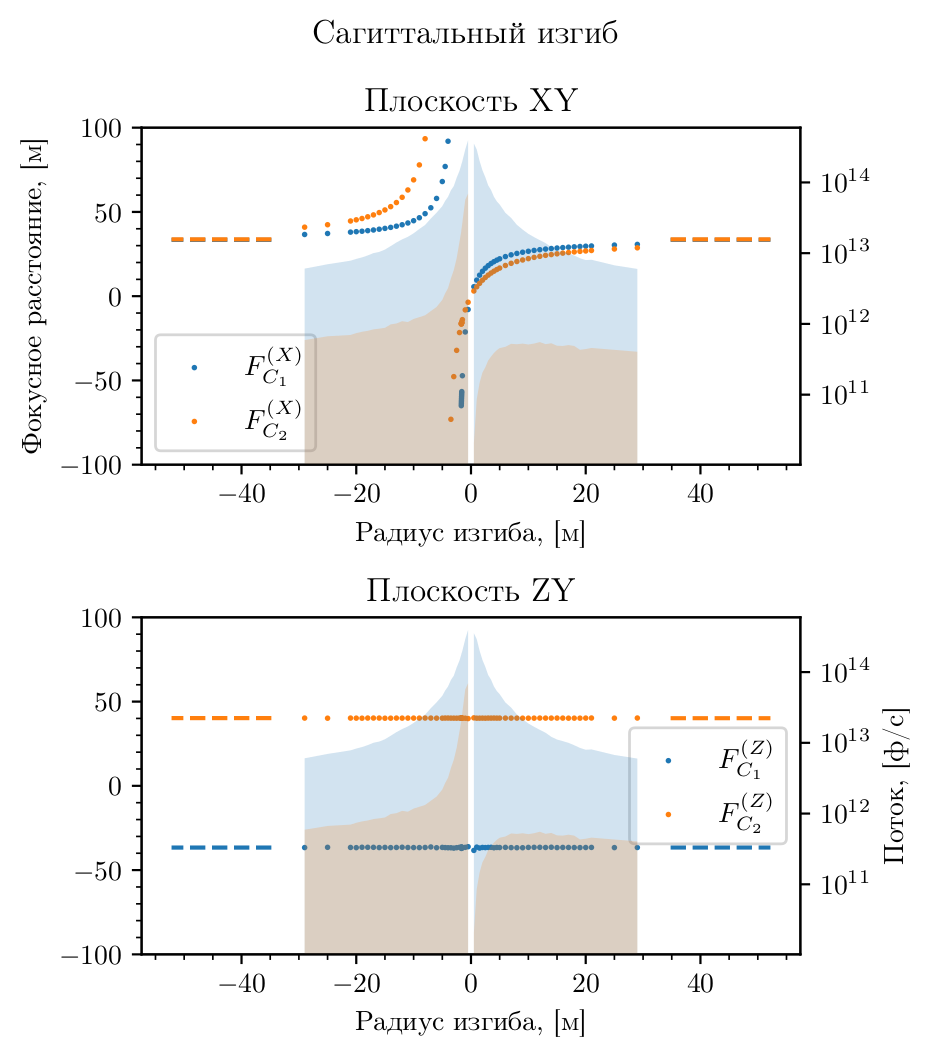

In [100]:
dd = '/Users/glebdovzhenko/Dropbox/PycharmProjects/skif-xrt/datasets/skif15/get_focus_s'

c1c2_cr_dist = np.sqrt(np.sum((np.array([0.0, 33594.21541931476, 12.5]) - np.array([0.0, 33500.0, 0.0]))**2))
em_cr_dist = np.sqrt(np.sum((np.array([0, 51000.0, 25.0]) - np.array([0.0, 33688.43083862951, 25.0]))**2))

r1x, r2x, r1y, r2y, r1_, r2_, f1x, f2x, f1y, f2y, flux1, flux2 = [], [], [], [], [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    
    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        k, b = get_line_kb(data, show=False)
        fdist = -np.sign(k) * np.sqrt((1. / k) ** 2 + (b / k) ** 2)
        
        if (metadata['name'] == 'C1C2') & (metadata['axes'] == 'XXpr'):
            f1x.append(-fdist + c1c2_cr_dist)
            r1x.append(metadata['r1'])
        elif (metadata['name'] == 'C1C2') & (metadata['axes'] == 'ZZpr'):
            f1y.append(-fdist + c1c2_cr_dist)
            r1y.append(metadata['r1'])
        elif (metadata['name'] == 'FM') & (metadata['axes'] == 'XXpr'):
            f2x.append(-fdist - em_cr_dist)
            r2x.append(metadata['r1'])
        elif (metadata['name'] == 'FM') & (metadata['axes'] == 'ZZpr'):
            f2y.append(-fdist - em_cr_dist)
            r2y.append(metadata['r1'])
        elif (metadata['name'] == 'C1C2') & (metadata['axes'] == 'XZ'):
            r1_.append(metadata['r1'])
            flux1.append(data.flux)
        elif (metadata['name'] == 'FM') & (metadata['axes'] == 'XZ'):
            r2_.append(metadata['r1'])
            flux2.append(data.flux)
        
r1x, r2x, r1y, r2y, r1_, r2_, f1x, f2x, f1y, f2y, flux1, flux2 = np.array(r1x), np.array(r2x), np.array(r1y), np.array(r2y), np.array(r1_), np.array(r2_), \
    np.array(f1x), np.array(f2x), np.array(f1y), np.array(f2y), np.array(flux1), np.array(flux2)
f1x *= 1e-3; f2x *= 1e-3; f1y *= 1e-3; f2y *= 1e-3
ii1 = np.argsort(r1_)
ii2 = np.argsort(r2_)
r1_, r2_, flux1, flux2 = r1_[ii1], r2_[ii2], flux1[ii1], flux2[ii2]

f1xp, f1xn = get_inf_points(r1x, f1x)
f2xp, f2xn = get_inf_points(r2x, f2x)
f1yp, f1yn = get_inf_points(r1y, f1y)
f2yp, f2yn = get_inf_points(r2y, f2y)

plt.close(fig)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.75, 4.75 * 18 / 16))
fig.suptitle('Сагиттальный изгиб')

ax1f = ax1.twinx()
ax1f.fill_between(r1_[r1_ > 0], flux1[r1_ > 0], np.ones(shape=flux1[r1_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1f.fill_between(r1_[r1_ < 0], flux1[r1_ < 0], np.ones(shape=flux1[r1_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1f.fill_between(r2_[r2_ > 0], flux2[r2_ > 0], np.zeros(shape=flux2[r2_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1f.fill_between(r2_[r2_ < 0], flux2[r2_ < 0], np.zeros(shape=flux2[r2_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1f.set_yscale('log')
ax1f.set_ylim(0.5 * np.min(flux2), 1.5 * np.max(flux1))

ax1.scatter(r1x, f1x, label='$F_{C_1}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:blue'], s=1)
ax1.scatter(r2x, f2x, label='$F_{C_2}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:orange'], s=1)
ax1.plot(*f1xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f1xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f2xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.plot(*f2xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.set_xlabel('Радиус изгиба, [м]')
ax1.set_ylabel('Фокусное расстояние, [м]')
ax1.set_title('Плоскость XY')
ax1.legend()

ax2.scatter(r1y, f1y, label='$F_{C_1}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:blue'], s=1)
ax2.scatter(r2y, f2y, label='$F_{C_2}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:orange'], s=1)
ax2.plot(*f1yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f1yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f2yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.plot(*f2yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.set_xlabel('Радиус изгиба, [м]')
ax2.set_title('Плоскость ZY')
ax2.legend()

ax2f = ax2.twinx()
ax2f.fill_between(r1_[r1_ > 0], flux1[r1_ > 0], np.ones(shape=flux1[r1_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2f.fill_between(r1_[r1_ < 0], flux1[r1_ < 0], np.ones(shape=flux1[r1_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2f.fill_between(r2_[r2_ > 0], flux2[r2_ > 0], np.zeros(shape=flux2[r2_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2f.fill_between(r2_[r2_ < 0], flux2[r2_ < 0], np.zeros(shape=flux2[r2_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2f.set_yscale('log')
ax2f.set_ylim(0.5 * np.min(flux2), 1.5 * np.max(flux1))
ax2f.set_ylabel('Поток, [ф/с]')

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax1f.yaxis.set_minor_locator(LogLocator(numticks=15))
ax2f.yaxis.set_minor_locator(LogLocator(numticks=15))

ax1.set_ylim(-100, 100)
ax2.set_ylim(-100, 100)
# ax1.set_ylim(33, 34)
# ax2.set_ylim(30, 40)
# ax1.set_xlim(-5, 5)
# ax1.set_ylim(-50, 50)

plt.tight_layout()

plt.savefig('focusing/sagittal.pgf')
plt.savefig('focusing/sagittal.pdf')

sagittal_f = np.stack((r1x, f1x)).T

fig

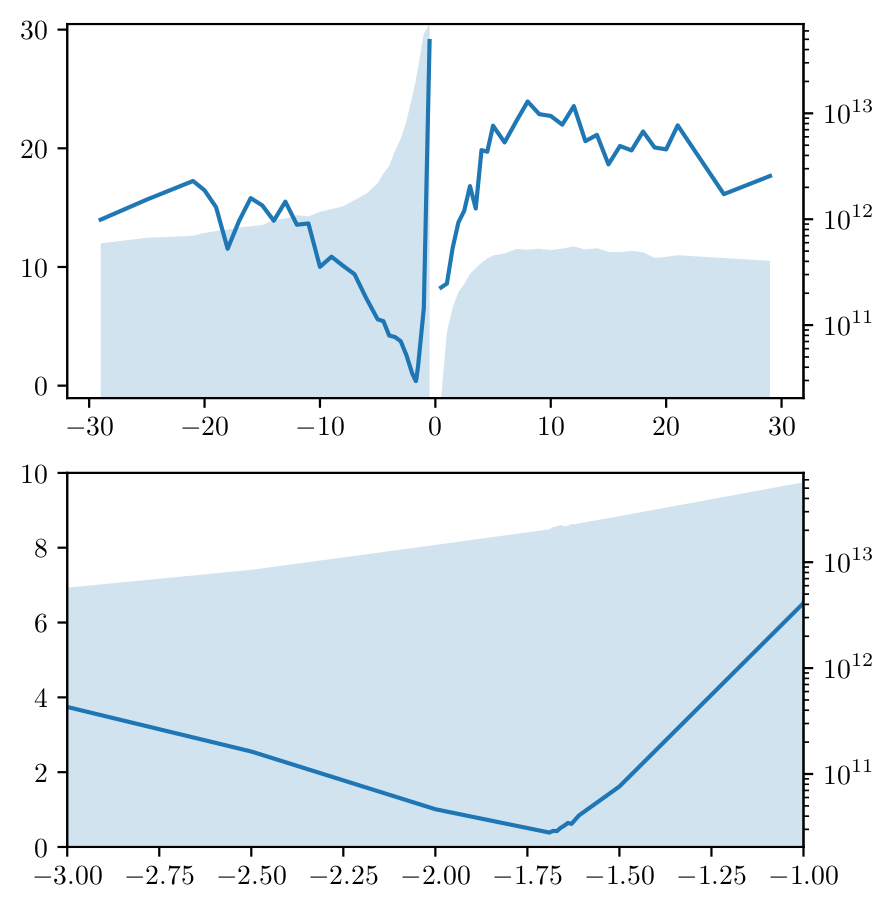

In [101]:
dd = '/Users/glebdovzhenko/Dropbox/PycharmProjects/skif-xrt/datasets/skif15/get_focus_s'

r, br, flux = [], [], []
for metadata in datafiles(dd):
    
    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        
        if (metadata['name'] == 'FM') & (metadata['axes'] == 'XZ'):
            r.append(metadata['r1'])
            br.append(get_integral_breadth(data, axis='x'))
            flux.append(data.flux)
        
r, br, flux = np.array(r), np.array(br), np.array(flux)
ii = np.argsort(r)
r, br, flux = r[ii], br[ii], flux[ii]

plt.close(fig)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.75, 4.75 * 18 / 16))
ax1t = ax1.twinx()
ax2t = ax2.twinx()

for ax, axt in ((ax1, ax1t), (ax2, ax2t)):
    ax.plot(r[r>0], br[r>0], color=mcolors.TABLEAU_COLORS['tab:blue'])
    ax.plot(r[r<0], br[r<0], color=mcolors.TABLEAU_COLORS['tab:blue'])
    axt.fill_between(r[r>0], flux[r>0], np.ones(shape=flux[r>0].shape), color=mcolors.TABLEAU_COLORS['tab:blue'], alpha=.2, linewidth=0)
    axt.fill_between(r[r<0], flux[r<0], np.ones(shape=flux[r<0].shape), color=mcolors.TABLEAU_COLORS['tab:blue'], alpha=.2, linewidth=0)
    axt.set_yscale('log')
    axt.set_ylim(np.min(flux), np.max(flux))

ax2.set_xlim(-3, -1)
ax2.set_ylim(0, 10)
fig

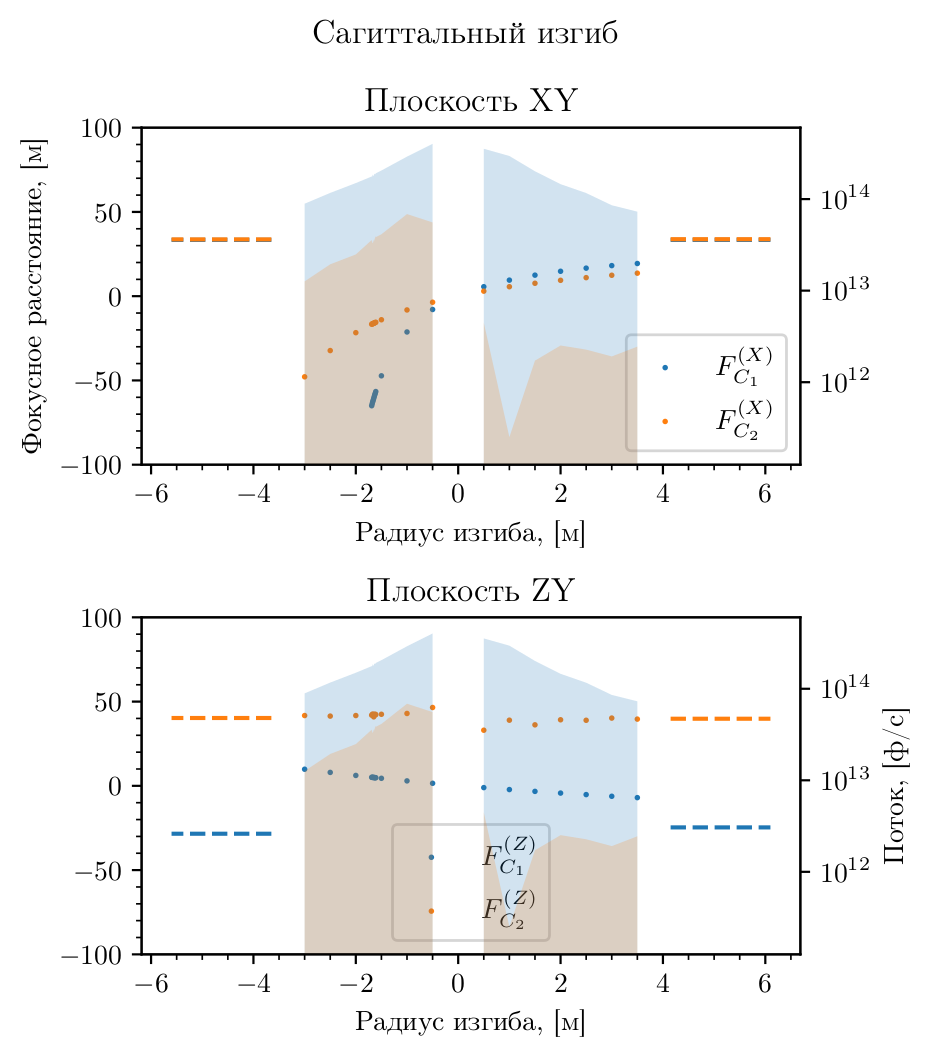

In [102]:
dd = '/Users/glebdovzhenko/Dropbox/PycharmProjects/skif-xrt/datasets/skif15/get_focus_s_'

c1c2_cr_dist = np.sqrt(np.sum((np.array([0.0, 33594.21541931476, 12.5]) - np.array([0.0, 33500.0, 0.0]))**2))
em_cr_dist = np.sqrt(np.sum((np.array([0, 51000.0, 25.0]) - np.array([0.0, 33688.43083862951, 25.0]))**2))

r1x, r2x, r1y, r2y, r1_, r2_, f1x, f2x, f1y, f2y, flux1, flux2 = [], [], [], [], [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    
    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        k, b = get_line_kb(data, show=False)
        fdist = -np.sign(k) * np.sqrt((1. / k) ** 2 + (b / k) ** 2)
        
        if (metadata['name'] == 'C1C2') & (metadata['axes'] == 'XXpr'):
            f1x.append(-fdist + c1c2_cr_dist)
            r1x.append(metadata['r1'])
        elif (metadata['name'] == 'C1C2') & (metadata['axes'] == 'ZZpr'):
            f1y.append(-fdist + c1c2_cr_dist)
            r1y.append(metadata['r1'])
        elif (metadata['name'] == 'FM') & (metadata['axes'] == 'XXpr'):
            f2x.append(-fdist - em_cr_dist)
            r2x.append(metadata['r1'])
        elif (metadata['name'] == 'FM') & (metadata['axes'] == 'ZZpr'):
            f2y.append(-fdist - em_cr_dist)
            r2y.append(metadata['r1'])
        elif (metadata['name'] == 'C1C2') & (metadata['axes'] == 'XZ'):
            r1_.append(metadata['r1'])
            flux1.append(data.flux)
        elif (metadata['name'] == 'FM') & (metadata['axes'] == 'XZ'):
            r2_.append(metadata['r1'])
            flux2.append(data.flux)
        
r1x, r2x, r1y, r2y, r1_, r2_, f1x, f2x, f1y, f2y, flux1, flux2 = np.array(r1x), np.array(r2x), np.array(r1y), np.array(r2y), np.array(r1_), np.array(r2_), \
    np.array(f1x), np.array(f2x), np.array(f1y), np.array(f2y), np.array(flux1), np.array(flux2)
f1x *= 1e-3; f2x *= 1e-3; f1y *= 1e-3; f2y *= 1e-3
ii1 = np.argsort(r1_)
ii2 = np.argsort(r2_)
r1_, r2_, flux1, flux2 = r1_[ii1], r2_[ii2], flux1[ii1], flux2[ii2]

f1xp, f1xn = get_inf_points(r1x, f1x)
f2xp, f2xn = get_inf_points(r2x, f2x)
f1yp, f1yn = get_inf_points(r1y, f1y)
f2yp, f2yn = get_inf_points(r2y, f2y)

plt.close(fig)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.75, 4.75 * 18 / 16))
fig.suptitle('Сагиттальный изгиб')

ax1f = ax1.twinx()
ax1f.fill_between(r1_[r1_ > 0], flux1[r1_ > 0], np.ones(shape=flux1[r1_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1f.fill_between(r1_[r1_ < 0], flux1[r1_ < 0], np.ones(shape=flux1[r1_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1f.fill_between(r2_[r2_ > 0], flux2[r2_ > 0], np.zeros(shape=flux2[r2_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1f.fill_between(r2_[r2_ < 0], flux2[r2_ < 0], np.zeros(shape=flux2[r2_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1f.set_yscale('log')
ax1f.set_ylim(0.5 * np.min(flux2), 1.5 * np.max(flux1))

ax1.scatter(r1x, f1x, label='$F_{C_1}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:blue'], s=1)
ax1.scatter(r2x, f2x, label='$F_{C_2}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:orange'], s=1)
ax1.plot(*f1xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f1xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f2xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.plot(*f2xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.set_xlabel('Радиус изгиба, [м]')
ax1.set_ylabel('Фокусное расстояние, [м]')
ax1.set_title('Плоскость XY')
ax1.legend()

ax2.scatter(r1y, f1y, label='$F_{C_1}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:blue'], s=1)
ax2.scatter(r2y, f2y, label='$F_{C_2}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:orange'], s=1)
ax2.plot(*f1yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f1yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f2yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.plot(*f2yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.set_xlabel('Радиус изгиба, [м]')
ax2.set_title('Плоскость ZY')
ax2.legend()

ax2f = ax2.twinx()
ax2f.fill_between(r1_[r1_ > 0], flux1[r1_ > 0], np.ones(shape=flux1[r1_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2f.fill_between(r1_[r1_ < 0], flux1[r1_ < 0], np.ones(shape=flux1[r1_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2f.fill_between(r2_[r2_ > 0], flux2[r2_ > 0], np.zeros(shape=flux2[r2_ > 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2f.fill_between(r2_[r2_ < 0], flux2[r2_ < 0], np.zeros(shape=flux2[r2_ < 0].shape), alpha=.2, linewidth=0, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2f.set_yscale('log')
ax2f.set_ylim(0.5 * np.min(flux2), 1.5 * np.max(flux1))
ax2f.set_ylabel('Поток, [ф/с]')

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax1f.yaxis.set_minor_locator(LogLocator(numticks=15))
ax2f.yaxis.set_minor_locator(LogLocator(numticks=15))

ax1.set_ylim(-100, 100)
ax2.set_ylim(-100, 100)
# ax1.set_ylim(33, 34)
# ax2.set_ylim(30, 40)
# ax1.set_xlim(-5, 5)
# ax1.set_ylim(-50, 50)

plt.tight_layout()

plt.savefig('focusing/sagittal2.pgf')
plt.savefig('focusing/sagittal2.pdf')

sagittal_f = np.stack((r1x, f1x)).T

fig